# Assessing impact of paid SEM on eBay Revenue

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
import os
sys.path.append(os.path.abspath("../"))
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from tqdm import tqdm
from synthdid.model import SynthDID  

raw_df = pd.read_csv('/Users/macbook/Downloads/PaidSearch.csv')

## Establishing the revenue time-series data to analyze
Taking the log of revenues for higher interpretability

In [2]:
Y_mat=raw_df.pivot(index=('dma','treated'), columns=("date",'treatment_period'))["revenue"]
Y_mat=Y_mat.sort_values(by=['treated'], axis=0).sort_values(by=['treatment_period'], axis=1)
logY=np.log(Y_mat)

## Calculating average revenues across treated observations

In [3]:
control =logY.iloc[:68,:]
treat = logY.iloc[68:,:]
rep_treat = np.mean(treat,axis =0)
CollapsedY = control.append(rep_treat,ignore_index = True)
CollapsedY.shape


(69, 113)

## Defining the pre- and post-treatment time periods, where paying for SEM is the treatment

In [4]:
pre_treat = [0,50]
post_treat = [51,113]
avg_treat = [68]
Y_input = CollapsedY.T.reset_index(drop=True)
base_mod = SynthDID(Y_input, pre_treat, post_treat, avg_treat)

##### Difference in Difference

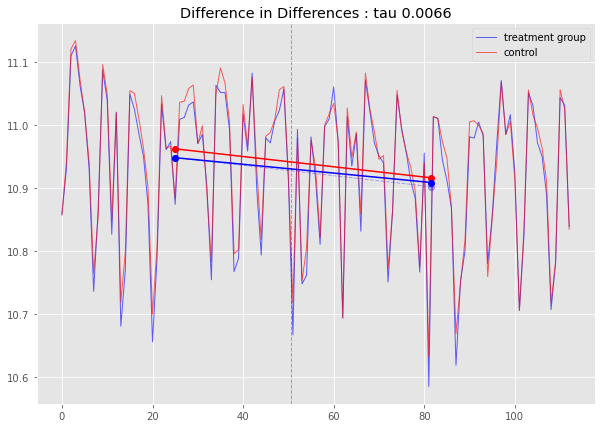

In [5]:
base_mod.fit(zeta_type="base")
hat_omega_simple = base_mod.estimated_params(model="sc")
base_mod.plot(model="did")

##### Synthetic Controls

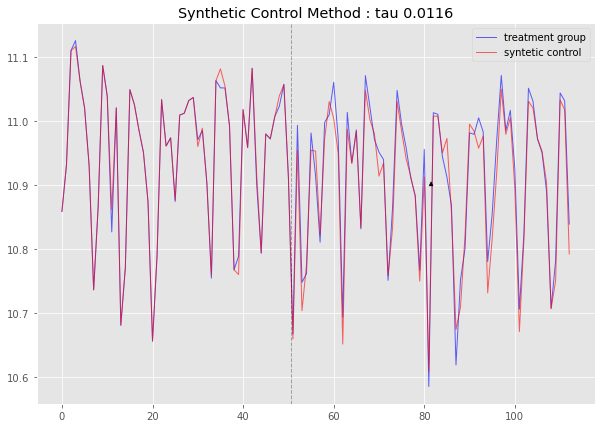

In [6]:
base_mod.fit(zeta_type="base")
hat_omega_simple = base_mod.estimated_params(model="sc")
base_mod.plot(model="sc")

##### Synthetic Difference in Differences

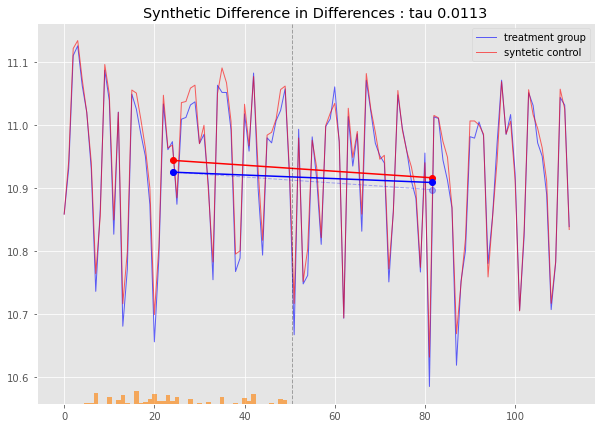

In [7]:
base_mod.fit(zeta_type="base")
hat_omega_simple = base_mod.estimated_params(model="sc")
base_mod.plot(model="sdid")

## Impact assessment between models

In [8]:
base_mod.cal_se(algo="placebo", replications=200)

100%|█████████████████████████████████████████| 200/200 [10:44<00:00,  3.22s/it]


In [9]:
base_mod.summary(model="did")

------------------------------------------------------------
Difference in Differences

point estimate: 0.007  (0.040)
95% CI (-0.071, 0.085)


In [10]:
base_mod.summary(model="sc")

------------------------------------------------------------
Syntetic Control Method

point estimate: 0.012  (0.080)
95% CI (-0.145, 0.168)


In [11]:
base_mod.summary(model="sdid")

------------------------------------------------------------
Syntetic Difference in Differences

point estimate: 0.011  (0.040)
95% CI (-0.067, 0.089)


## Conclusions

What is most surprising is that for each of our estimation methods, we derive positive estimates of $\tau$, our treatment effect.  The standard Diff-in-Diff (DID) stood just apart from the other two methods with an estimated treatment effect of .007, which equates to a 0.7 percentage point increase in sales at eBay when they quit paying for SEM. Our Synthetic Control (SC) method estimate closely resembled the Synthetic Diff-in-Diff (SDID) estimate at 0.012 and 0.011, respectively. Thus SC and SDID estimate a 1.1 and 1.2 percentage point increase in sales if eBay quits paying for SEM. 

What is perhaps most important is that the standard errors on each of our models' estimates are large enough that none of them are 'statistically significant'. Our confidence intervals are split between positive and negative values, so we can't rule out that the treatment effect was negative either. Ultimately, we can't be confident about whether or not the treatment helps or hurts sales, but it does seem likely that the magnitude of the effect is negligible. Considering the fact that eBay could utilize their SEM budget in other ways, these results indicate that they should reallocate those funds to other efforts. In 'Business Data Science' Matt Taddy makes an important note on this conclusion: these results are very likely driven by the fact that eBay is so well known that it appears in search results organically. A less known company might have very different results.